In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from src.modeling.create_data_split import split_data
from src.utils.models_pkl import load_pickle

In [2]:
from config.config_data import DATA_PATH
from config.config_modeling import CAT_COLS, TRAIN_SIZE, TEST_FROM_VAL, RANDOM_STATE

In [3]:
MODEL_PATH = Path("..") / ".." / "models" / "XGB.pkl"
DATA_PATH = "../.." / Path(DATA_PATH.parent / "data_plain.csv")

In [4]:
model = load_pickle(MODEL_PATH)

data = pd.read_csv(DATA_PATH)

split_data = split_data(
    cols=CAT_COLS,
    df=data,
    train_size=TRAIN_SIZE,
    test_size=TEST_FROM_VAL,
    random_state=RANDOM_STATE,
)

In [5]:
X_train = split_data["train"][0]
y_train = split_data["train"][1]
X_test = split_data["test"][0]
y_test = split_data["test"][1]

In [6]:
# Train the XGBoost model
model.fit(X_train, y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eta=0.1, eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, ...)

#### Linear Regression as a Surrogate Model

In [7]:
# Train a Linear Regression as a surrogate model to approximate XGBoost predictions
logistic_reggression_surrogate = LogisticRegression(random_state=42, max_iter=1000)
logistic_reggression_surrogate.fit(X_train, model.predict(X_train))

/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614

LogisticRegression(max_iter=1000, random_state=42)

In [8]:
logistic_regression_cv = LogisticRegressionCV(Cs=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5, max_iter=1000)
logistic_regression_cv.fit(X_train, y_train)

# Get the optimal c value
optimal_c = 1 / logistic_regression_cv.C_[0]
print(optimal_c)

logistic_regression_surrogate_cv = LogisticRegression(C=optimal_c, max_iter=1000)
logistic_regression_surrogate_cv.fit(X_train, y_train)
lasso_coefficients = logistic_regression_surrogate_cv.coef_

/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614

10.0


/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614

In [9]:
# Evaluate the surrogate model's performance
surrogate_predictions = logistic_reggression_surrogate.predict(X_train)
cv_surrogate_predictions = logistic_regression_surrogate_cv.predict(X_train)

# Calculate accuracy
auc = roc_auc_score(y_train, surrogate_predictions)
auc_cv = roc_auc_score(y_train, cv_surrogate_predictions)

print("Logistic Regression Surrogate Model AUC: {:.4f}".format(auc))
print("CV Logistic Regression Surrogate Model AUC: {:.4f}".format(auc_cv))

Logistic Regression Surrogate Model AUC: 0.5964
CV Logistic Regression Surrogate Model AUC: 0.6007


/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614

In [10]:
# Get the coefficients of the surrogate model
coef = logistic_reggression_surrogate.coef_
coef_cv = logistic_regression_surrogate_cv.coef_

# Get feature names (assuming X_train is a DataFrame)
feature_names = X_train.columns

In [11]:
# Order by the absolute values of coefficients
importance_df = pd.DataFrame(
    {"Feature Name": feature_names, "LR Coefficients": coef[0], "CV Coefficients": coef_cv[0]}
)

importance_df["Absolute Coefficients"] = importance_df["LR Coefficients"].abs()
importance_df = importance_df.sort_values(by="Absolute Coefficients", ascending=False)
importance_df = importance_df.drop(columns="Absolute Coefficients")
pd.options.display.float_format = "{:.2f}".format

print("Feature Importances (Ordered by Absolute Coefficient Value):")
print(importance_df)

Feature Importances (Ordered by Absolute Coefficient Value):
                     Feature Name  LR Coefficients  CV Coefficients
2         Contributed.To.Accident             3.47             1.78
4                 Property.Damage             3.00             1.47
3                 Personal.Injury             2.18             1.10
10                       Speeding            -1.16            -0.43
7                 Driver_State_MD             1.16             0.56
9               Fail.Obey.Signals             0.91             0.40
8                     DL_State_MD            -0.77            -0.32
0                           Belts             0.67             0.47
30                    Make_subaru            -0.54            -0.25
35                  Race_HISPANIC             0.52             0.35
27                  Make_mercedes             0.49             0.21
6                        State_MD            -0.47            -0.20
23                   Make_hyundai            -0.36     

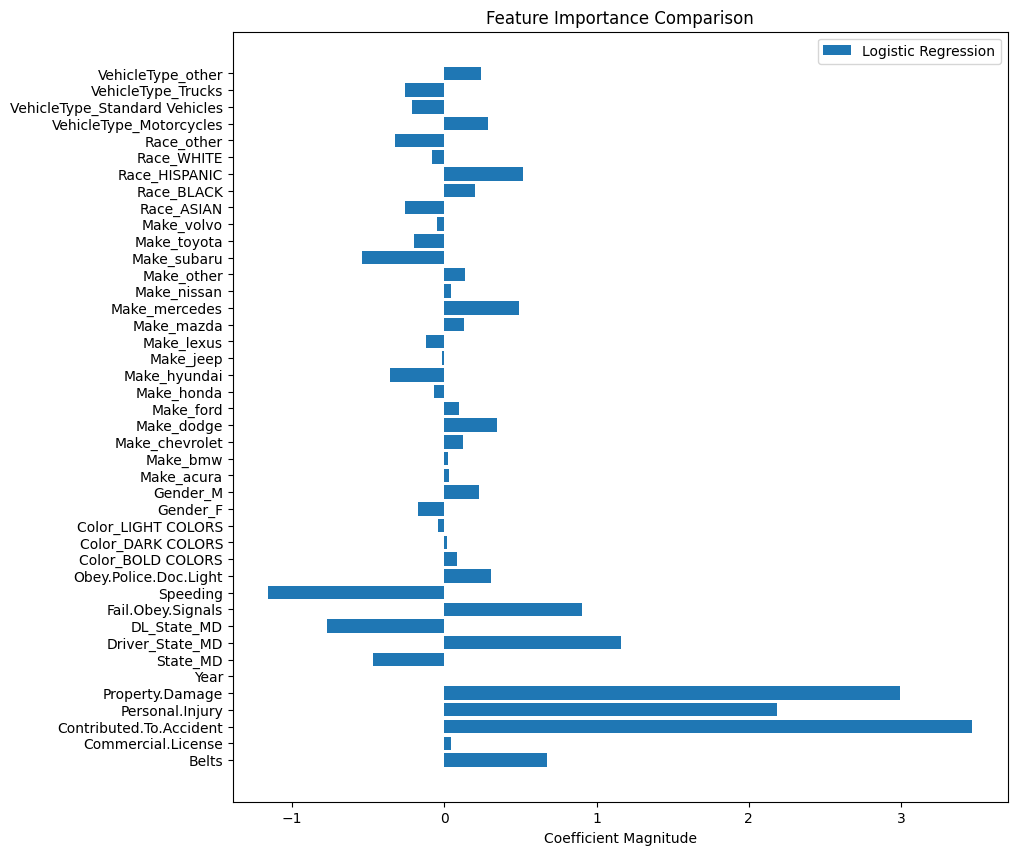

In [12]:
# Plot the feature importance
fig, ax = plt.subplots(figsize=(10, 10))

# ax.barh(feature_names, coef_cv[0], alpha=0.7, label="CV Regression", color="green")
ax.barh(feature_names, coef[0], label="Logistic Regression")

ax.set_title("Feature Importance Comparison")
ax.set_xlabel("Coefficient Magnitude")
ax.legend()
plt.show()

#### Decision Tree as a Surrogate Model

/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: Futur

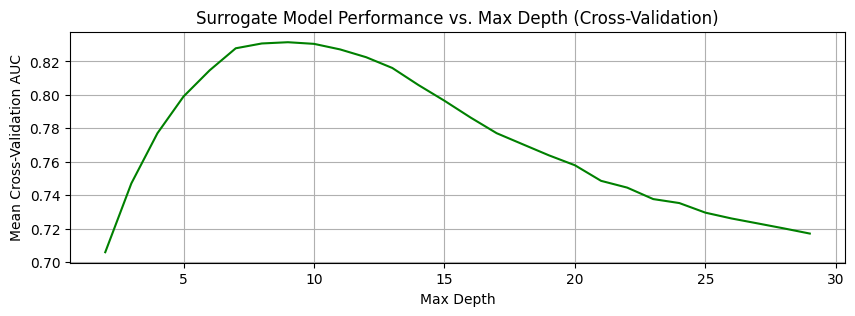

In [13]:
# Define a range of maximum depths to test
max_depths = list(range(2, 30))
cv_scores = []

# Iterate over different max_depth values and perform cross-validation
for max_depth in max_depths:
    decision_tree_surrogate = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(decision_tree_surrogate, X_train, y_train, cv=5, scoring="roc_auc")
    mean_accuracy = np.mean(scores)
    cv_scores.append(mean_accuracy)

# Plot the mean cross-validation scores vs. max depth
plt.figure(figsize=(10, 3))
plt.plot(max_depths, cv_scores, color="green")
plt.xlabel("Max Depth")
plt.ylabel("Mean Cross-Validation AUC")
plt.title("Surrogate Model Performance vs. Max Depth (Cross-Validation)")
plt.grid(True)
plt.show()

In [14]:
# Train a Decision Tree as a surrogate model to approximate XGBoost predictions
max_depth = 3

decision_tree_surrogate = DecisionTreeClassifier(max_depth=max_depth)
decision_tree_surrogate.fit(X_train, model.predict(X_train))

/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614

DecisionTreeClassifier(max_depth=3)

In [15]:
# Evaluate the surrogate model's performance
decision_tree_surrogate_preds = decision_tree_surrogate.predict(X_test)

surrogate_auc = roc_auc_score(y_test, decision_tree_surrogate_preds)
print("Decision Tree Surrogate Model AUC: {:.2f}".format(surrogate_auc))

Decision Tree Surrogate Model AUC: 0.68


/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M2/14_algorithmic-fairness-and-interpretability/project-fairness-interpretability/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614

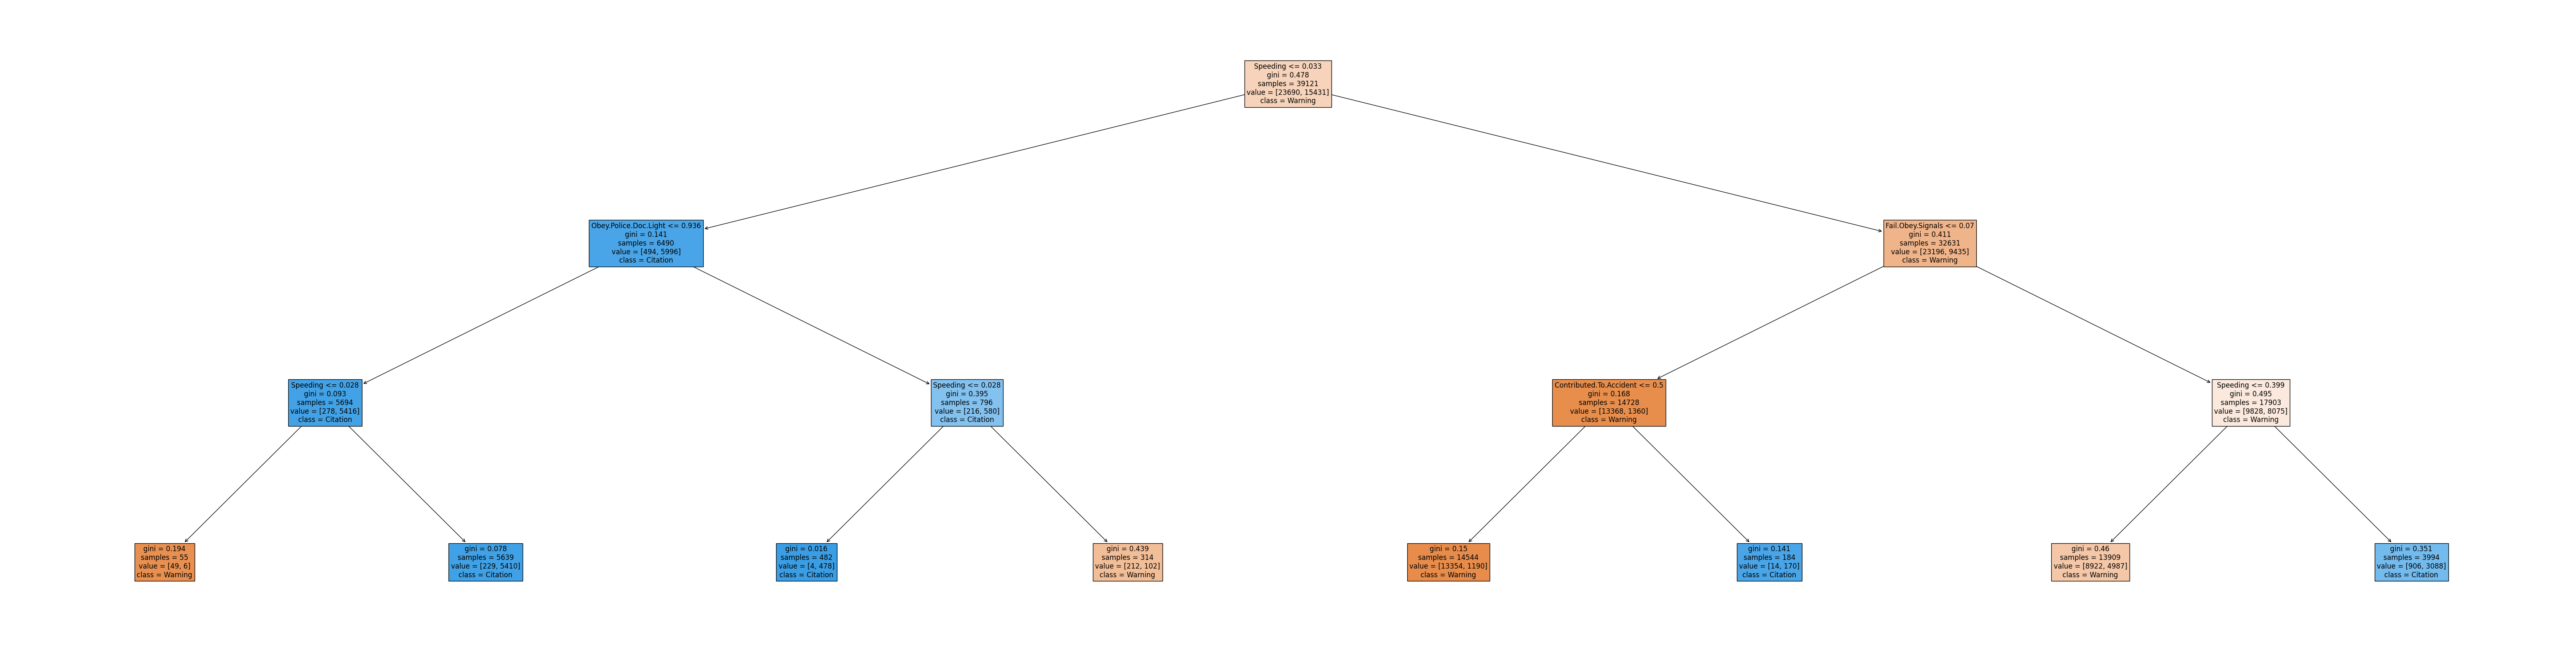

In [16]:
# Decision Tree Visualization
plt.figure(figsize=(80, 20))
plot_tree(
    decision_tree_surrogate,
    filled=True,
    feature_names=X_train.columns,
    class_names=["Warning", "Citation"],
    fontsize=12,
)
plt.show()

In [17]:
feature_importance = decision_tree_surrogate.feature_importances_
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_idx = feature_importance.argsort()

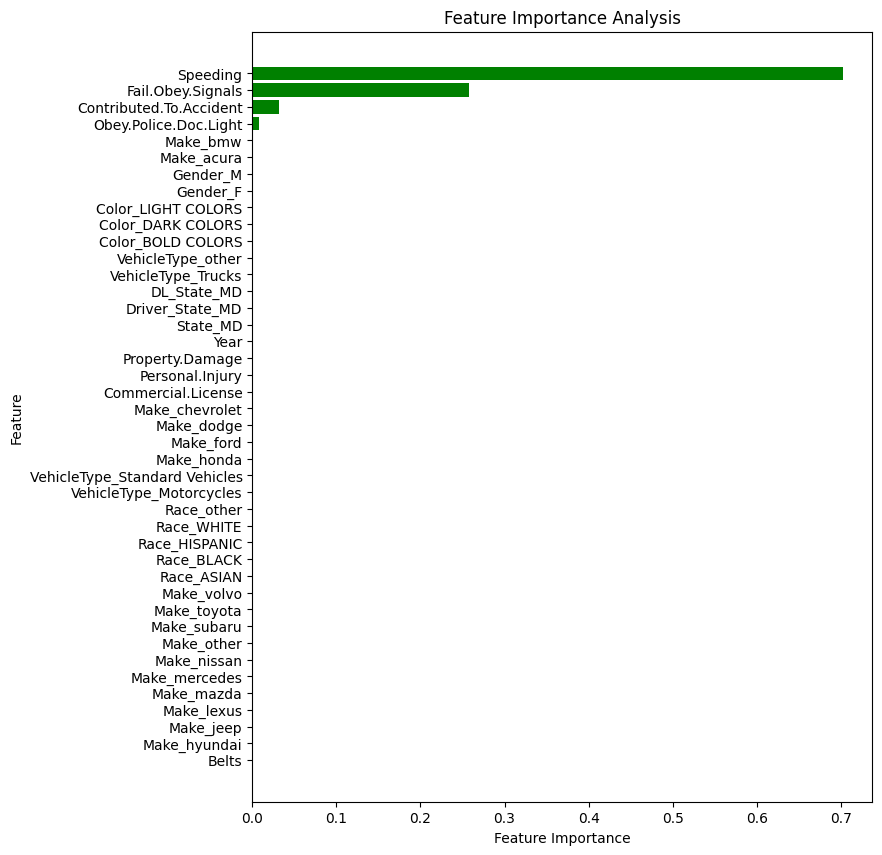

In [18]:
# Feature Importance Plot

plt.figure(figsize=(8, 10))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx], color="green")
plt.yticks(range(X_train.shape[1]), [feature_names[i] for i in sorted_idx])
plt.ylabel("Feature")
plt.xlabel("Feature Importance")
plt.title("Feature Importance Analysis")
plt.show()